### todo
- stationary and passive noise reduction

In [4]:
import IPython
from scipy.io import wavfile
import noisereduce as nr
import soundfile as sf
from noisereduce.generate_noise import band_limited_noise
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
import io
%matplotlib inline

/home/AD/tsainbur/anaconda3/envs/neuroethology/lib/python3.7/site-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [156]:
### load data

In [157]:
url = "https://auditoryneuroscience.com/sites/default/files/bushOffersPeace.ogg"
response = urllib.request.urlopen(url)
data, rate = sf.read(io.BytesIO(response.read()))

In [158]:
len(data),rate

(200542, 44100)

### add noise

In [159]:
noise_len = 2 # seconds
noise = band_limited_noise(min_freq=2000, max_freq = 12000, samples=len(data), samplerate=rate)*5
noise_clip = noise[:rate*noise_len]
audio_clip_band_limited = data+noise

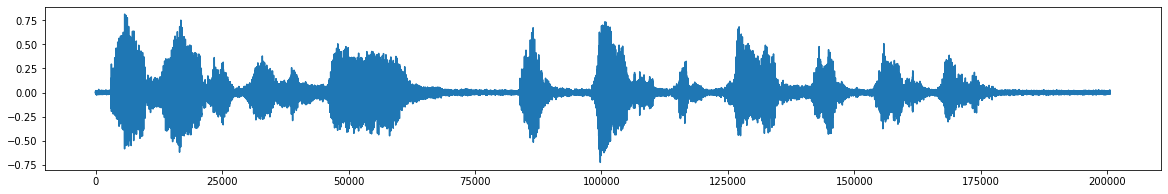

In [160]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(audio_clip_band_limited)

In [1]:
# write a bandpass filter that works on chunks

In [32]:
from tqdm.autonotebook import tqdm

In [193]:
data.dtype

dtype('float64')

In [223]:
import librosa
from scipy.signal import filtfilt
import scipy

In [ ]:
def sigmoid(x, shift, mult):
    """
    Using this sigmoid to discourage one network overpowering the other
    """
    return 1 / (1 + np.exp(-(x + shift) * mult))

def get_time_smoothed_representation(
    spectral, samplerate, hop_length, time_constant=0.001
):
    t_frames = time_constant * samplerate / float(hop_length)
    # By default, this solves the equation for b:
    #   b**2  + (1 - b) / t_frames  - 2 = 0
    # which approximates the full-width half-max of the
    # squared frequency response of the IIR low-pass filt
    b = (np.sqrt(1 + 4 * t_frames ** 2) - 1) / (2 * t_frames ** 2)
    return filtfilt([b], [1, b - 1], spectral, axis=-1, padtype=None)

def _smoothing_filter(n_grad_freq, n_grad_time):
    """Generates a filter to smooth the mask for the spectrogram
        
    Arguments:
        n_grad_freq {[type]} -- [how many frequency channels to smooth over with the mask.]
        n_grad_time {[type]} -- [how many time channels to smooth over with the mask.]
    """
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    return smoothing_filter

class SpectralGateRecording:
    def __init__(
        self,
        y,  # data (frames, channels)
        sr,  # sampling rate
        chunk_size=60000,
        padding=30000,
        n_fft = 1024,
        win_length = None,
        hop_length = None,
        time_constant = 2.0,
        freq_smooth_hz = 500,
        time_smooth_ms = 50,
        thresh_n_mult = 1,
        sigmoid_slope = 10,
        tmp_folder = None,
    ):
        self.sr = sr
        # if this is a 1D single channel recording
        self.flat = False

        y = np.array(y)
        # reshape data to (#channels, #frames)
        if len(y.shape) == 1:
            self.y = np.expand_dims(y, 0)
            self.flat = True
        elif len(y.shape) > 2:
            raise ValueError("Waveform must be in shape (# frames, # channels)")
        else:
            self.y = y

        self._dtype = y.dtype
        # get the number of channels and frames in data
        self.n_channels, self.n_frames = self.y.shape
        self._chunk_size = chunk_size
        self.padding = padding
        
        # where to create a temp file for parallel
        # writing
        self._tmp_folder = tmp_folder
        
        ### Parameters for spectral gating
        self._n_fft = n_fft
        # set window and hop length for stft
        if win_length is None:
            self._win_length = self._n_fft
        else:
            self._win_length = win_length
        if hop_length is None:
            self._hop_length = self._win_length // 4
        self._time_constant = time_constant
        self._thresh_n_mult = thresh_n_mult
        self._sigmoid_slope = sigmoid_slope
        
        if (freq_smooth_hz is None) & (time_smooth_ms is None):
            self.smooth_mask = False
        else:
            self._generate_mask_smoothing_filter(freq_smooth_hz, time_smooth_ms)
        
    def _generate_mask_smoothing_filter(self, freq_smooth_hz, time_smooth_ms):
        
        if freq_smooth_hz is None:
            n_grad_freq = 1
        else:
            # filter to smooth the mask
            n_grad_freq = int(freq_smooth_hz / (self.sr / (self._n_fft/2)))
            if n_grad_freq < 1:
                raise ValueError('freq_smooth_hz needs to be at least {}Hz'.format(
                  int((self.sr / (self._n_fft/2)))  
                ))
            
        if time_smooth_ms is None:
            n_grad_time = 1
        else:
            n_grad_time = int(time_smooth_ms / ((self._hop_length/self.sr)*1000))
            if n_grad_time < 1:
                raise ValueError('time_smooth_ms needs to be at least {}ms'.format(
                  int((self._hop_length/self.sr)*1000)
                ))
        if (n_grad_time == 1) & (n_grad_freq == 1):
            self.smooth_mask = False
        else:
            self.smooth_mask = True
            self._smoothing_filter = _smoothing_filter(n_grad_freq, n_grad_time)
        
    def _read_chunk(self, i1, i2):
        """read chunk and pad with zerros"""
        if i1 < 0:
            i1b = 0
        else:
            i1b = i1
        if i2 > self.n_frames:
            i2b = self.n_frames
        else:
            i2b = i2
        chunk = np.zeros((self.n_channels, i2 - i1))
        chunk[:, i1b - i1 : i2b - i1] = self.y[:, i1b:i2b]
        return chunk

    def filter_chunk(self, start_frame, end_frame):
        """Pad and perform filtering"""
        i1 = start_frame - self.padding
        i2 = end_frame + self.padding
        padded_chunk = self._read_chunk(i1, i2)
        filtered_padded_chunk = self._do_filter(padded_chunk)
        return filtered_padded_chunk[:, start_frame - i1 : end_frame - i1]

    def _get_filtered_chunk(self, ind):
        """Grabs a single chunk"""
        start0 = ind * self._chunk_size
        end0 = (ind + 1) * self._chunk_size
        return self.filter_chunk(start_frame=start0, end_frame=end0)

    
    def spectral_gating_nonstationary(self, chunk):
        """ non-stationary version of spectral gating
        """
        denoised_channels = np.zeros(chunk.shape, chunk.dtype)
        for ci, channel in enumerate(chunk):
            sig_stft = librosa.stft(
                (channel), n_fft= self._n_fft, hop_length=self._hop_length, win_length=self._win_length,
            )
            # get abs of signal stft
            abs_sig_stft = np.abs(sig_stft)

            # get the smoothed mean of the signal
            sig_stft_smooth = get_time_smoothed_representation(
                abs_sig_stft, self.sr, self._hop_length, time_constant=self._time_constant
            )

            # get the number of X above the mean the signal is
            sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
            # mask based on sigmoid
            sig_mask = sigmoid(sig_mult_above_thresh, -self._thresh_n_mult, self._sigmoid_slope)

            if self.smooth_mask:
                # convolve the mask with a smoothing filter
                sig_mask = scipy.signal.fftconvolve(sig_mask, self._smoothing_filter, mode="same")

            # multiply signal with mask
            sig_stft_denoised = sig_stft * sig_mask
            
            # invert/recover the signal
            denoised_signal = librosa.istft(
                sig_stft_denoised, hop_length=self._hop_length, win_length=self._win_length
            )
            denoised_channels[ci,:len(denoised_signal)] =denoised_signal
        return denoised_channels
    
    def _do_filter(self, chunk):
        """Do the actual filtering"""
        chunk_filtered = self.spectral_gating_nonstationary(chunk)

        return chunk_filtered
    
    def _iterate_chunk(self, filtered_chunk):
        filtered_chunk0 = self._get_filtered_chunk(ich)
        if ich == ich1:
            start0 = start_frame - ich * self._chunk_size
        else:
            start0 = 0
        if ich == ich2:
            end0 = end_frame - ich * self._chunk_size
        else:
            end0 = self._chunk_size
        filtered_chunk[:, pos : pos + end0 - start0] = filtered_chunk0[
            :, start0:end0
        ]
        pos += end0 - start0
        
    def get_traces(self, start_frame=None, end_frame=None):
        """Grab filtered data iterating over chunks"""
        if start_frame is None:
            start_frame = 0
        if end_frame is None:
            end_frame = self.n_frames

        if self._chunk_size is not None:
            if end_frame - start_frame > self._chunk_size:
                ich1 = int(start_frame / self._chunk_size)
                ich2 = int((end_frame - 1) / self._chunk_size)
                filtered_chunk = np.zeros(
                    (self.n_channels, int(end_frame - start_frame)), dtype=self._dtype
                )
                print(ich1, ich2, start_frame, end_frame, self._chunk_size)
                pos = 0
                for ich in tqdm(range(ich1, ich2 + 1)):
                    filtered_chunk0 = self._get_filtered_chunk(ich)
                    if ich == ich1:
                        start0 = start_frame - ich * self._chunk_size
                    else:
                        start0 = 0
                    if ich == ich2:
                        end0 = end_frame - ich * self._chunk_size
                    else:
                        end0 = self._chunk_size
                    filtered_chunk[:, pos : pos + end0 - start0] = filtered_chunk0[
                        :, start0:end0
                    ]
                    pos += end0 - start0
                
                return filtered_chunk.astype(self._dtype).flatten()
            
        filtered_chunk = self.filter_chunk(start_frame=0, end_frame=end_frame)
        return filtered_chunk.astype(self._dtype).flatten()

In [360]:
from joblib import Parallel, delayed
def sigmoid(x, shift, mult):
    """
    Using this sigmoid to discourage one network overpowering the other
    """
    return 1 / (1 + np.exp(-(x + shift) * mult))


def get_time_smoothed_representation(
    spectral, samplerate, hop_length, time_constant=0.001
):
    t_frames = time_constant * samplerate / float(hop_length)
    # By default, this solves the equation for b:
    #   b**2  + (1 - b) / t_frames  - 2 = 0
    # which approximates the full-width half-max of the
    # squared frequency response of the IIR low-pass filt
    b = (np.sqrt(1 + 4 * t_frames ** 2) - 1) / (2 * t_frames ** 2)
    return filtfilt([b], [1, b - 1], spectral, axis=-1, padtype=None)


def _smoothing_filter(n_grad_freq, n_grad_time):
    """Generates a filter to smooth the mask for the spectrogram

    Arguments:
        n_grad_freq {[type]} -- [how many frequency channels to smooth over with the mask.]
        n_grad_time {[type]} -- [how many time channels to smooth over with the mask.]
    """
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    return smoothing_filter


class SpectralGateRecording:
    def __init__(
        self,
        y,  # data (frames, channels)
        sr,  # sampling rate
        chunk_size=60000,
        padding=30000,
        n_fft=1024,
        win_length=None,
        hop_length=None,
        time_constant=2.0,
        freq_smooth_hz=500,
        time_smooth_ms=50,
        thresh_n_mult=1,
        sigmoid_slope=10,
        tmp_folder=None,
        n_jobs = 1
    ):
        self.sr = sr
        # if this is a 1D single channel recording
        self.flat = False

        y = np.array(y)
        # reshape data to (#channels, #frames)
        if len(y.shape) == 1:
            self.y = np.expand_dims(y, 0)
            self.flat = True
        elif len(y.shape) > 2:
            raise ValueError("Waveform must be in shape (# frames, # channels)")
        else:
            self.y = y

        self._dtype = y.dtype
        # get the number of channels and frames in data
        self.n_channels, self.n_frames = self.y.shape
        self._chunk_size = chunk_size
        self.padding = padding
        self.n_jobs = n_jobs

        # where to create a temp file for parallel
        # writing
        self._tmp_folder = tmp_folder

        ### Parameters for spectral gating
        self._n_fft = n_fft
        # set window and hop length for stft
        if win_length is None:
            self._win_length = self._n_fft
        else:
            self._win_length = win_length
        if hop_length is None:
            self._hop_length = self._win_length // 4
        self._time_constant = time_constant
        self._thresh_n_mult = thresh_n_mult
        self._sigmoid_slope = sigmoid_slope

        if (freq_smooth_hz is None) & (time_smooth_ms is None):
            self.smooth_mask = False
        else:
            self._generate_mask_smoothing_filter(freq_smooth_hz, time_smooth_ms)

    def _generate_mask_smoothing_filter(self, freq_smooth_hz, time_smooth_ms):

        if freq_smooth_hz is None:
            n_grad_freq = 1
        else:
            # filter to smooth the mask
            n_grad_freq = int(freq_smooth_hz / (self.sr / (self._n_fft / 2)))
            if n_grad_freq < 1:
                raise ValueError(
                    "freq_smooth_hz needs to be at least {}Hz".format(
                        int((self.sr / (self._n_fft / 2)))
                    )
                )

        if time_smooth_ms is None:
            n_grad_time = 1
        else:
            n_grad_time = int(time_smooth_ms / ((self._hop_length / self.sr) * 1000))
            if n_grad_time < 1:
                raise ValueError(
                    "time_smooth_ms needs to be at least {}ms".format(
                        int((self._hop_length / self.sr) * 1000)
                    )
                )
        if (n_grad_time == 1) & (n_grad_freq == 1):
            self.smooth_mask = False
        else:
            self.smooth_mask = True
            self._smoothing_filter = _smoothing_filter(n_grad_freq, n_grad_time)

    def _read_chunk(self, i1, i2):
        """read chunk and pad with zerros"""
        if i1 < 0:
            i1b = 0
        else:
            i1b = i1
        if i2 > self.n_frames:
            i2b = self.n_frames
        else:
            i2b = i2
        chunk = np.zeros((self.n_channels, i2 - i1))
        chunk[:, i1b - i1 : i2b - i1] = self.y[:, i1b:i2b]
        return chunk

    def filter_chunk(self, start_frame, end_frame):
        """Pad and perform filtering"""
        i1 = start_frame - self.padding
        i2 = end_frame + self.padding
        padded_chunk = self._read_chunk(i1, i2)
        filtered_padded_chunk = self._do_filter(padded_chunk)
        return filtered_padded_chunk[:, start_frame - i1 : end_frame - i1]

    def _get_filtered_chunk(self, ind):
        """Grabs a single chunk"""
        start0 = ind * self._chunk_size
        end0 = (ind + 1) * self._chunk_size
        return self.filter_chunk(start_frame=start0, end_frame=end0)

    def spectral_gating_nonstationary(self, chunk):
        """non-stationary version of spectral gating"""
        denoised_channels = np.zeros(chunk.shape, chunk.dtype)
        for ci, channel in enumerate(chunk):
            sig_stft = librosa.stft(
                (channel),
                n_fft=self._n_fft,
                hop_length=self._hop_length,
                win_length=self._win_length,
            )
            # get abs of signal stft
            abs_sig_stft = np.abs(sig_stft)

            # get the smoothed mean of the signal
            sig_stft_smooth = get_time_smoothed_representation(
                abs_sig_stft,
                self.sr,
                self._hop_length,
                time_constant=self._time_constant,
            )

            # get the number of X above the mean the signal is
            sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
            # mask based on sigmoid
            sig_mask = sigmoid(
                sig_mult_above_thresh, -self._thresh_n_mult, self._sigmoid_slope
            )

            if self.smooth_mask:
                # convolve the mask with a smoothing filter
                sig_mask = scipy.signal.fftconvolve(
                    sig_mask, self._smoothing_filter, mode="same"
                )

            # multiply signal with mask
            sig_stft_denoised = sig_stft * sig_mask

            # invert/recover the signal
            denoised_signal = librosa.istft(
                sig_stft_denoised,
                hop_length=self._hop_length,
                win_length=self._win_length,
            )
            denoised_channels[ci, : len(denoised_signal)] = denoised_signal
        return denoised_channels

    def _do_filter(self, chunk):
        """Do the actual filtering"""
        chunk_filtered = self.spectral_gating_nonstationary(chunk)

        return chunk_filtered

    def _iterate_chunk(self, filtered_chunk, pos, end0, start0, ich):
        filtered_chunk0 = self._get_filtered_chunk(ich)
        filtered_chunk[:, pos : pos + end0 - start0] = filtered_chunk0[:, start0:end0]
        pos += end0 - start0

    def get_traces(self, start_frame=None, end_frame=None):
        """Grab filtered data iterating over chunks"""
        if start_frame is None:
            start_frame = 0
        if end_frame is None:
            end_frame = self.n_frames

        if self._chunk_size is not None:
            if end_frame - start_frame > self._chunk_size:
                ich1 = int(start_frame / self._chunk_size)
                ich2 = int((end_frame - 1) / self._chunk_size)
                
                # write output to temp memmap for parallelization
                with tempfile.NamedTemporaryFile(prefix=self._tmp_folder) as fp:
                    # create temp file
                    filtered_chunk = np.memmap(
                        fp,
                        dtype=self._dtype,
                        shape=(self.n_channels, int(end_frame - start_frame)),
                        mode="w+",
                    )
                    pos_list = []
                    start_list = []
                    end_list = []
                    pos = 0
                    for ich in range(ich1, ich2 + 1):
                        if ich == ich1:
                            start0 = start_frame - ich * self._chunk_size
                        else:
                            start0 = 0
                        if ich == ich2:
                            end0 = end_frame - ich * self._chunk_size
                        else:
                            end0 = self._chunk_size
                        pos_list.append(pos)
                        start_list.append(start0)
                        end_list.append(end0)
                        pos += end0 - start0
                    
                    Parallel(n_jobs=self.n_jobs)(delayed(self._iterate_chunk)(filtered_chunk, pos, end0, start0, ich)
                       for pos, start0, end0, ich in zip(
                        tqdm(pos_list), start_list, end_list, range(ich1, ich2 + 1)
                    )
                   )
                    
                    #for pos, start0, end0, ich in zip(
                    #    pos_list, start_list, end_list, range(ich1, ich2 + 1)
                    #):
                    #    self._iterate_chunk(filtered_chunk, pos, end0, start0, ich)

                    return filtered_chunk.astype(self._dtype).flatten()

        filtered_chunk = self.filter_chunk(start_frame=0, end_frame=end_frame)
        return filtered_chunk.astype(self._dtype).flatten()

In [361]:
sg = SpectralGateRecording(audio_clip_band_limited, rate, thresh_n_mult = 2, sigmoid_slope=40)

In [362]:
reduced_noise = sg.get_traces()

  0%|          | 0/4 [00:00<?, ?it/s]

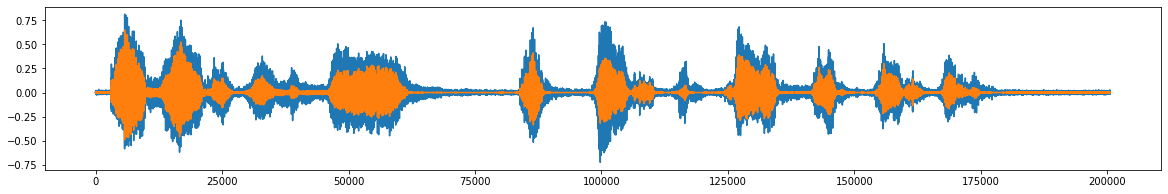

In [363]:
fig, ax = plt.subplots(figsize=(20,3))
plt.plot(audio_clip_band_limited)
plt.plot(reduced_noise)

In [364]:
IPython.display.Audio(data=reduced_noise, rate=rate)

In [365]:
from noisereduce.noisereduce import reduce_noise

In [369]:
audio_clip_band_limited

array([-0.0008106 , -0.00117158,  0.00396447, ..., -0.00248266,
        0.00240362,  0.00256012])

In [370]:
reduce_noise(y = audio_clip_band_limited, sr=rate)

TypeError: reduce_noise() got an unexpected keyword argument 'y'

In [371]:
noisereduce.__file__

NameError: name 'noisereduce' is not defined